In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from data_loader import VideoFrameDataset
from pretrained_model import CompressAIWrapper


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model = CompressAIWrapper(quality=3).to(device)
model.load_state_dict(torch.load('../saved_models/compressai.pth', map_location=device))
model.eval()

print("Model loaded successfully.")

Model loaded successfully.


Dataset size: 646 frames
Frame shape: torch.Size([3, 64, 64])


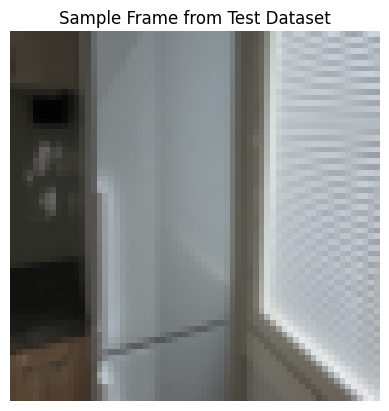

In [4]:
# Load test dataset
img_size = 64  # This value should match the ones used during training
dataset = VideoFrameDataset(root_dir='../test_data', img_size=(img_size, img_size))

# Check dataset size and a sample frame
print(f"Dataset size: {len(dataset)} frames")

# Display one sample frame and visualize it
sample_idx = 0
sample_frame = dataset[sample_idx]
print(f"Frame shape: {sample_frame.shape}")
plt.imshow(sample_frame.permute(1, 2, 0))
plt.title("Sample Frame from Test Dataset")
plt.axis('off')
plt.show()

In [13]:
batch_size = 8
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
batch = next(iter(dataloader)).to(device)

with torch.no_grad():
    out = model(batch)
    print(type(out))
    print(len(out))
    print("First item type:", type(out[0]))
    recon_batch = out[0]

batch_cpu = batch.cpu()
recon_cpu = recon_batch.cpu()

print("Reconstruction completed.")

<class 'tuple'>
2
First item type: <class 'torch.Tensor'>
Reconstruction completed.


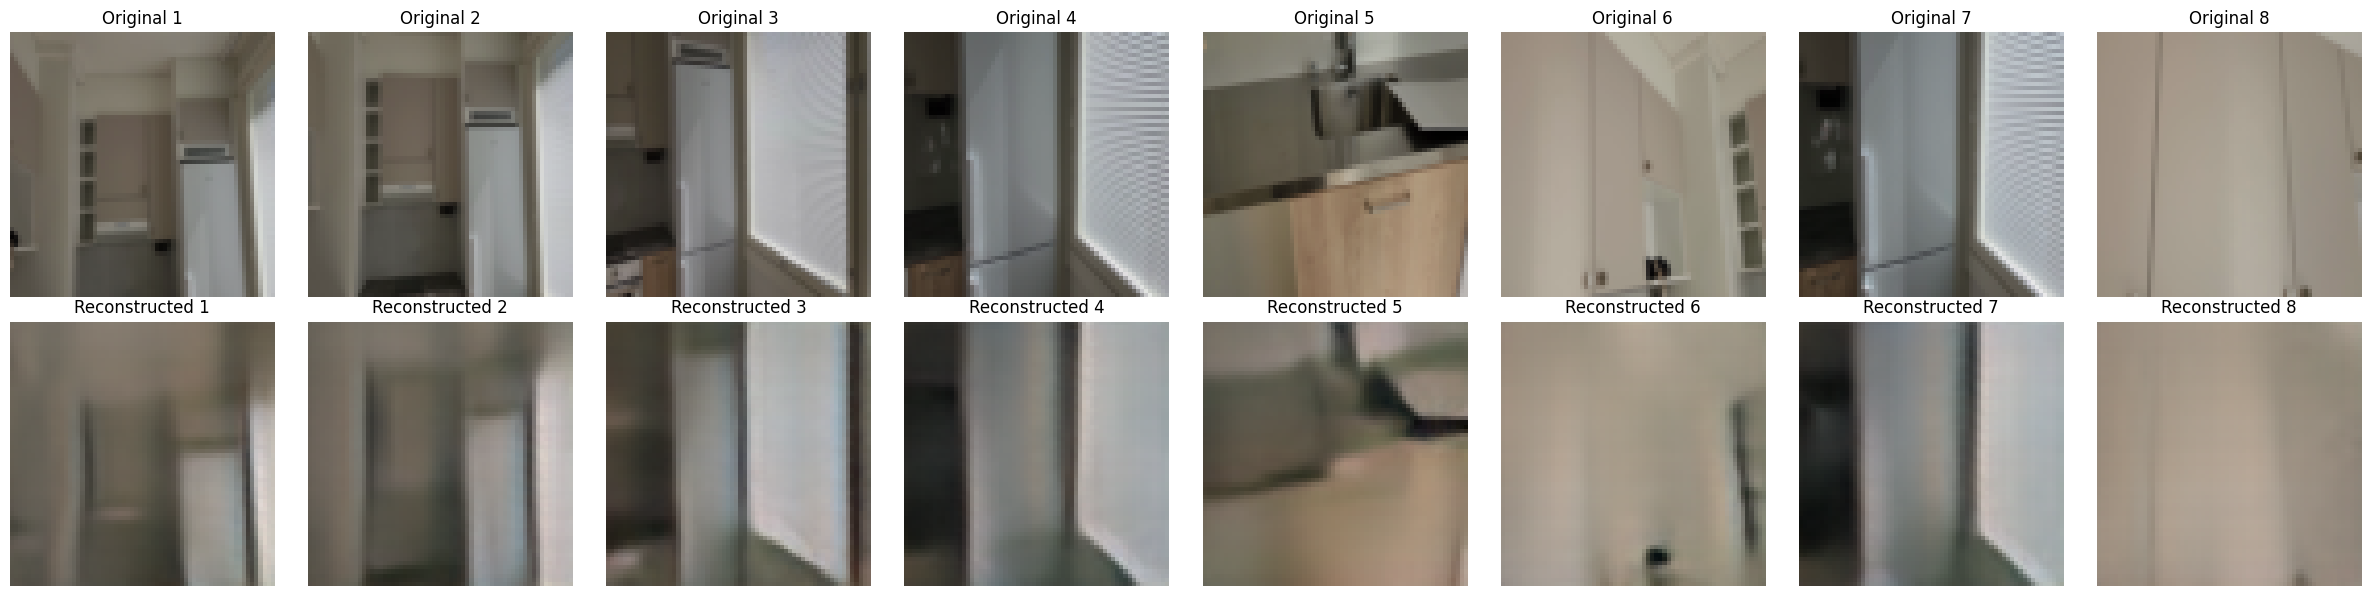

In [18]:
def show_images(original, reconstructed, num_images=4):
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 3, 6))

    for i in range(num_images):
        axes[0, i].imshow(original[i].permute(1, 2, 0))
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Original {i+1}')

        axes[1, i].imshow(reconstructed[i].permute(1, 2, 0))
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Reconstructed {i+1}')

    plt.tight_layout()
    plt.savefig('../output/model_test.png')
    plt.show()

# Display comparison
show_images(batch_cpu, recon_cpu, num_images=batch_size)

In [15]:
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def compute_metrics(original, reconstructed):
    original = original.numpy().transpose(1, 2, 0)
    reconstructed = reconstructed.numpy().transpose(1, 2, 0)

    psnr_value = psnr(original, reconstructed, data_range=1)
    ssim_value = ssim(original, reconstructed, channel_axis=-1, data_range=1)

    return psnr_value, ssim_value

psnr_vals = []
ssim_vals = []

for i in range(batch_size):
    psnr_value, ssim_value = compute_metrics(batch_cpu[i], recon_cpu[i])
    psnr_vals.append(psnr_value)
    ssim_vals.append(ssim_value)
    print(f"Image {i+1}: PSNR = {psnr_value:.2f}, SSIM = {ssim_value:.4f}")

print(f"\nAverage PSNR: {np.mean(psnr_vals):.2f}")
print(f"Average SSIM: {np.mean(ssim_vals):.4f}")

Image 1: PSNR = 28.09, SSIM = 0.8032
Image 2: PSNR = 28.46, SSIM = 0.8281
Image 3: PSNR = 27.89, SSIM = 0.8464
Image 4: PSNR = 27.87, SSIM = 0.7652
Image 5: PSNR = 27.45, SSIM = 0.7911
Image 6: PSNR = 29.29, SSIM = 0.8298
Image 7: PSNR = 27.83, SSIM = 0.7645
Image 8: PSNR = 33.24, SSIM = 0.8889

Average PSNR: 28.76
Average SSIM: 0.8146
